# boundary_conditions_finalize

> Add regularization term to avoid cells collapsing to very small areas, and improve boundary conditions by including two cell rows


In [ ]:
#| default_exp boundary_finalize

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev

In [ ]:
#| export
from CE_simulation.triangle import *
from CE_simulation.tension import *
from CE_simulation.delaunay import *
from CE_simulation.isogonal import *

In [ ]:
#| export
import os
import sys
import importlib

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.collections import LineCollection

from numpy import sin, cos, tan, pi, sqrt, arccos, arctan, arctan2
from numpy.linalg import norm

from scipy.integrate import solve_ivp
from scipy import ndimage
from scipy import spatial
from scipy import optimize
from scipy import linalg

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

from collections import Counter, defaultdict

In [ ]:
#| export

from dataclasses import dataclass
from typing import Union, Dict, List, Tuple, Iterable, Callable
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import ipywidgets as widgets
from matplotlib import animation, rc

In [ ]:
#| export

import jax.numpy as jnp
from jax import grad as jgrad
from jax import jit
from jax.tree_util import Partial
from jax.config import config
from jax.nn import relu as jrelu

config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
#config.update("jax_debug_nans", True)  # useful for debugging, but makes code slower!

In [ ]:
fridtjof_colors = np.array([[0.34398, 0.49112, 0.89936],
[0.97, 0.606, 0.081],
[0.91, 0.318, 0.243],
[0.448, 0.69232, 0.1538],
[0.62168, 0.2798, 0.6914],
[0.09096, 0.6296, 0.85532],
[0.46056, 0.40064, 0.81392],
[0.94, 0.462, 0.162],
[0., 0.7, 0.7],
[0.827051, 0.418034, 0.0243459],
[0.5511749434976025, 0.32014794962639853, 0.8720626412559938],
[0.72694101250947, 0.7196601125010522, 0.],
[0.8680706456216862, 0.2563858708756628, 0.30321559063052295],
[0.2418693812442152, 0.5065044950046278, 0.9902432574930582],
[0.9573908706237908, 0.5369543531189542, 0.11504464931576472]])

## Import select functions from other boundary notebook

In [ ]:
from CE_simulation.boundary_jax import get_triangular_lattice, create_rect_mesh, get_centroid,\
                                       get_bdry, get_conformal_transform, get_areas,\
                                       get_primal_energy_fct_jax, get_E, get_E_jac, polygon_area,\
                                       excitable_dt_act_pass, euler_step, flatten_triangulation_jax,\
                                       get_tri_areas, get_flip_edge, optimize_cell_shape,\
                                       create_rect_mesh_angle

## Simulation with boundary conditions and passive & active cells

## create mesh - hexagonal lattice parallel to strain

In [ ]:
## create mesh

np.random.seed(0)
mesh_initial = create_rect_mesh(14, 30, noise=0.1, defects=(0,0), straight_bdry=True) #0.075 False

center = np.mean([v.coords for v in mesh_initial.vertices.values()], axis=0)
mesh_initial.transform_vertices(lambda x: x-center)
mesh_initial.set_centroid()

for v in mesh_initial.vertices.values():
    v.rest_shape = sqrt(3)*np.eye(2)

mesh_initial.transform_vertices(shear_mat(1.15))  #1
mesh_initial.set_rest_lengths()

In [ ]:
## set the boundary conditions and mark the active and passive vertices

passive_ids = []
active_ids = []
bdry_up_ids = []
bdry_down_ids = []

max_y = np.max([val.dual_coords[1] for val in mesh_initial.faces.values()])
w_passive = 6  # 5.5
for fc in mesh_initial.faces.values():
    if fc.is_bdr():  # make a passive edge - let's see if that is necessary
        passive_ids.append(fc._fid)
    if np.abs(fc.dual_coords[1]) > (max_y-w_passive):
        passive_ids.append(fc._fid)
    else:
        active_ids.append(fc._fid)

passive_ids = sorted(passive_ids)
active_ids = sorted(active_ids)

# create list of passive cells
passive_cells = [v._vid for v in mesh_initial.vertices.values()
                 if not v.is_bdry() and any([fc._fid in passive_ids for fc in v.get_face_neighbors()])]

max_y_cells = np.max([v.get_centroid()[1] for v in mesh_initial.vertices.values() if not v.is_bdry()])

w_bdry = .2
for v in mesh_initial.vertices.values():
    # check vertex is a full valued cell
    if (v.get_centroid()[1] > (max_y_cells-w_bdry)) and (not v.is_bdry()):
        bdry_up_ids.append(v._vid)
    if (v.get_centroid()[1] < -(max_y_cells-w_bdry)) and (not v.is_bdry()):
        bdry_down_ids.append(v._vid)

In [ ]:
print(max_y_cells)

11.724941148653096


In [ ]:
## create the penalty functions

bdry_y = 12

def up_penalty(x):
    return (x[1]-bdry_y)**2
def down_penalty(x):
    return (x[1]+bdry_y)**2

up_penalty = Partial(jit(up_penalty))
down_penalty = Partial(jit(down_penalty))

bdry_list = ([up_penalty, bdry_up_ids], [down_penalty, bdry_down_ids])

## create mesh - hexagonal orthogonal to strain

Works well looks like!

In [ ]:
## create mesh

np.random.seed(1)
mesh_initial = create_rect_mesh(48, 36, noise=0.15, defects=(0, 0), straight_bdry=False) #0.075 False
#noise = .1,  (24, 18), (48, 36)

mesh_initial.transform_vertices(rot_mat(pi/2))
center = np.mean([v.coords for v in mesh_initial.vertices.values()], axis=0)
mesh_initial.transform_vertices(lambda x: x-center)
mesh_initial.set_voronoi()

mesh_initial.transform_vertices(shear_mat(1.15))
mesh_initial.set_rest_lengths()

In [ ]:
## set the boundary conditions and mark the active and passive vertices

passive_ids = []
active_ids = []

max_y = np.max([val.dual_coords[1] for val in mesh_initial.faces.values()])
w_passive = 8 # 6
for fc in mesh_initial.faces.values():
    if fc.is_bdr():  # make a passive edge - let's see if that is necessary
        passive_ids.append(fc._fid)
    if np.abs(fc.dual_coords[1]) > (max_y-w_passive):
        passive_ids.append(fc._fid)
    else:
        active_ids.append(fc._fid)

passive_ids = sorted(passive_ids)
active_ids = sorted(active_ids)

# create list of passive cells
passive_cells = [v._vid for v in mesh_initial.vertices.values()
                 if not v.is_bdry() and any([fc._fid in passive_ids for fc in v.get_face_neighbors()])]

max_y_cells = np.max([v.get_centroid()[1] for v in mesh_initial.vertices.values() if not v.is_bdry()])

w_bdry = .4

bdry_up_ids= []
bdry_down_ids = []

for v in mesh_initial.vertices.values():
    # check vertex is a full valued cell
    if (v.get_centroid()[1] > (max_y_cells-w_bdry)) and (not v.is_bdry()):
        bdry_up_ids.append(v._vid)
    if (v.get_centroid()[1] < -(max_y_cells-w_bdry)) and (not v.is_bdry()):
        bdry_down_ids.append(v._vid)


In [ ]:
print(max_y_cells)

22.933859515884947


In [ ]:
## create the penalty functions

bdry_y = 23 # 11

def up_penalty(x):
    return (x[1]-(bdry_y))**2
def down_penalty(x):
    return (x[1]+(bdry_y))**2

up_penalty = Partial(jit(up_penalty))
down_penalty = Partial(jit(down_penalty))


bdry_list = ([up_penalty, bdry_up_ids], [down_penalty, bdry_down_ids])


### Plot initial condition

In [ ]:
#| notest
%matplotlib inline

In [ ]:
initial_y_dict = {key: np.round((2/np.sqrt(3))*val.get_centroid()[1]+.5, decimals=0) # for parr
                  #key: np.round(val.get_centroid()[1], decimals=0) # for orth
                  for key, val in mesh_initial.vertices.items()
                  if (not key in passive_cells) and (not val.is_bdry())}

color = 'fridtjof' # tab10

if color == 'tab10':
    color_norm = lambda x: ((x-min(initial_y_dict.values())) % 10) / 10 # tab10
elif color == 'fridtjof':
    color_norm = lambda x: int((x-min(initial_y_dict.values())) % 15)
initial_y_dict = {key: color_norm(val) for key, val in initial_y_dict.items()}

alpha = .5

if color == 'tab10':
    cmap = mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap=mpl.cm.tab10)  #tab10
    cell_colors = {key: np.array(cmap.to_rgba(color_norm(val)))*np.array([1,1,1,alpha])
                        for key, val in initial_y_dict.items()} # tab10

elif color == 'fridtjof':
    cell_colors = {key: np.hstack([fridtjof_colors[val], [.5]]) for key, val in initial_y_dict.items()}

(-12.5, 12.5)

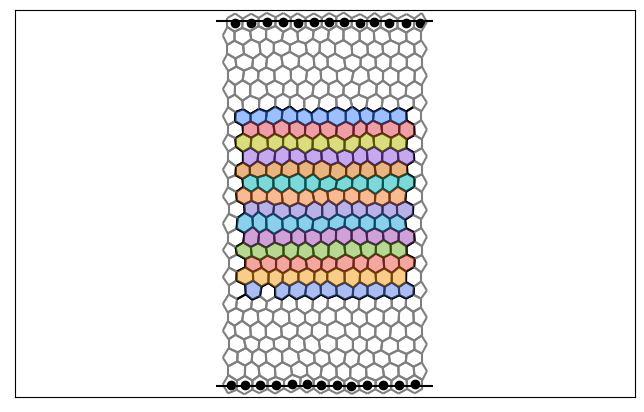

In [ ]:
## plot

passive_edges = flatten([[he._heid for he in mesh_initial.faces[fc].hes] for fc in passive_ids])
edge_colors = {key: "tab:grey" for key in passive_edges}

fig = plt.figure(figsize=(8,8))

mesh_initial.cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
#mesh_initial.triplot()

#mesh_initial.labelplot()

plt.hlines((bdry_y-.25, -bdry_y+.25), (-7, -7), (7, 7), color="k")

#for key in passive_cells: # double check passive cells are correctly identified
#    plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="g")

for key in bdry_up_ids+bdry_down_ids:
    plt.scatter(*mesh_initial.vertices[key].get_centroid(), c="k")

msh = mesh_initial
_, cell_list_vids = msh.get_primal_energy_fct_jax()
is_bdr = np.array([any([fc.is_bdr() for fc in msh.vertices[v].get_face_neighbors()])
                  for v in cell_list_vids])
             
plt.gca().set_aspect("equal", adjustable="box");
plt.xticks([],[])
plt.yticks([],[])
plt.xlim([-20, 20])
plt.ylim([-bdry_y-.5, bdry_y+.5])

#plt.savefig("plots/initial_cond.pdf")

In [ ]:
# add a column of passive cells at the sides?

### To do parameters: minimize the number of helper regularization parameters

`mod_area`, `mod_shear`, `k3`, `tri_reg_A`

- `tri_reg_A`: important.
- `mod_area`: not important
- `k3`: less important, only for active cells at boundary. job mostly done by triangle area regularization
- `mod_shear`: essential. no extension without shear modulus!

### set simulation parameters

In [ ]:
## feedback parameters

m = 4
k = .5
k3 = .1 # regularization term
 
def params_pattern(fid):
    if fid in passive_ids:
        return {"k": .25, "m": 1} # lower k here makes the passive region less lattice-like
    # might add an extra case for the edges in slip-wall boundary cells
    return {"k": k, "m": 4, "k3": k3}

params_no_pattern = {"k": k, "m": m, "k3": k3}
    
dt = .001 # 0.01 too large for m=4! .001
n_steps = 200
forbid_reflip = 20
minimal_l = .075 # 0.05 is a bit low. maybe even .1 ??

tri_mod_area = .01 # triangle area regularization

In [ ]:
n_steps*dt

0.2

In [ ]:
## cell shape parameters

tol, maxiter = (1e-4, 20000) # .5*1e-4, 
mod_bulk = 1
mod_shear = .5 # .5
angle_penalty = 1000
bdry_penalty = 5000

epsilon_l = 1e-3

A0 = jnp.sqrt(3)/2
mod_area = 0

bdr_weight = 2

#cell_id_to_modulus = None 
rel_elastic_modulus = .8 # reduction in elastic modulus in passive cells
cell_id_to_modulus = np.vectorize(lambda x: 1-rel_elastic_modulus*(x in passive_cells))

energy_args = {"mod_bulk": mod_bulk, "mod_shear": mod_shear,
               "angle_penalty": angle_penalty, "bdry_penalty": bdry_penalty, "epsilon_l": epsilon_l,
               "A0": A0, "mod_area": mod_area}

use_voronoi = False # don't do shape optimization, run voronoi instead

In [ ]:
## isogonal mode

k_rest = 0 # 2

iso = 0 # .25 #.29
for v in mesh_initial.vertices.values():
    v.rest_shape = sqrt(3) * np.array([[1-iso, 0],[0, 1+iso]])

def rhs_rest_shape(v):
    """Rest shape relaxation but do not relax area, i.e. trace. Also, only relax passive cells"""
    #if v._vid in passive_cells:
    #    delta = v.rest_shape-v.get_shape_tensor()
    #    return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))
    #else:
    #    return 0
    delta = v.rest_shape-v.get_shape_tensor()
    return -k_rest*(delta - np.trace(delta)/2 * np.eye(2))


In [ ]:
meshes = [deepcopy(mesh_initial)]
times = [0]
last_flipped_edges = [[]] # T1_count = np.cumsum([len(x) for x in last_flipped_edge])

# version where all meshes are saved at each modification step, not each time step
meshes_alt = [deepcopy(meshes[0])] 
times_alt = [0]
last_flipped_edges_alt = [[]]

In [ ]:
save = True
dir_name = "germ_band_medium_parr_v2"
if save:
    os.mkdir(f"runs/{dir_name}/")

FileExistsError: [Errno 17] File exists: 'runs/germ_band_medium_parr_v2/'

In [ ]:
## simulation loop

mesh = deepcopy(meshes[-1])
for i in tqdm(range(110, n_steps)):
    # euler step
    mesh.euler_step(dt=dt, rhs=excitable_dt_act_pass, params=params_pattern, rhs_rest_shape=rhs_rest_shape)
    # flatten triangulation
    mesh.flatten_triangulation_jax(mod_area=tri_mod_area, tol=1e-4)
    # primal optimization
    if use_voronoi:
        mesh.set_voronoi()
    else:
        mesh.optimize_cell_shape(bdry_list=bdry_list, energy_args=energy_args,
                                 cell_id_to_modulus=cell_id_to_modulus,
                                 tol=tol, maxiter=maxiter, verbose=True, bdr_weight=bdr_weight)
    # check for intercalation
    flipped = []
    failed_flip = []
    flip_edge = get_flip_edge(mesh, minimal_l=minimal_l,
                              exclude=list(flatten(last_flipped_edges[-forbid_reflip:])))
    while flip_edge is not None:
        try:
            print(f"flip {flip_edge}, tpt {i}")
            he = mesh.hes[flip_edge]
            mesh.flip_edge(flip_edge)
            mesh.reset_rest_passive_flip(he, method="smooth")
            f0, f1 = (he.face, he.twin.face)
            f0.dual_coords, f1.dual_coords = rotate_about_center(np.stack([f0.dual_coords, f1.dual_coords]))
            flipped.append(he._heid)
            if use_voronoi:
                mesh.set_voronoi()
            else:
                mesh.optimize_cell_shape(bdry_list=bdry_list, energy_args=energy_args,
                                         cell_id_to_modulus=cell_id_to_modulus,
                                         tol=tol, maxiter=maxiter, verbose=True)
            exclude = list(flatten(last_flipped_edges[-forbid_reflip:]))+flipped+failed_flip
            flip_edge = get_flip_edge(mesh, minimal_l=minimal_l, exclude=exclude)
            
            last_flipped_edges_alt.append([he._heid])
            meshes_alt.append(deepcopy(mesh))
            times_alt.append(times[-1])
        except ValueError:
            print(f"failed flip {flip_edge}, tpt {i}")
            failed_flip.append(flip_edge)
            exclude = list(flatten(last_flipped_edges[-forbid_reflip:]))+flipped+failed_flip
            flip_edge = get_flip_edge(mesh, minimal_l=minimal_l, exclude=exclude)
            continue

    # rescale & reorient triangulation
    mesh.transform_vertices(get_conformal_transform(meshes[-1], mesh))
    # log
    last_flipped_edges.append(flipped)
    meshes.append(deepcopy(mesh))
    times.append(times[-1]+dt)
    if save:
        mesh.save_mesh(f"runs/{dir_name}/{str(i).zfill(4)}_mesh.txt")
        rest_dict = {key: val.rest_shape for key, val in mesh.vertices.items()}
        pickle.dump(rest_dict, open(f"runs/{dir_name}/{str(i).zfill(4)}_rest_shape.p", "wb"))
        passive_dict = {key: val.passive for key, val in mesh.hes.items()}
        pickle.dump(passive_dict, open(f"runs/{dir_name}/{str(i).zfill(4)}_passive.p", "wb"))
        # all other info should be contained in mesh
    last_flipped_edges_alt.append([])
    meshes_alt.append(deepcopy(mesh))
    times_alt.append(times[-1]+dt)

last_flipped_edges.append_([])
last_flipped_edges_alt.append([])

  0%|          | 0/90 [00:00<?, ?it/s]

flip 288, tpt 110
failed flip 288, tpt 110
flip 1905, tpt 110
failed flip 1905, tpt 110
flip 1894, tpt 110
failed flip 1894, tpt 110
flip 2323, tpt 110
flip 1896, tpt 110
failed flip 1896, tpt 110
flip 2325, tpt 110
Cell shape optimization failed Maximum number of iterations has been exceeded.
flip 1249, tpt 110
failed flip 1249, tpt 110
flip 717, tpt 110
failed flip 717, tpt 110
flip 1287, tpt 110
failed flip 1287, tpt 110
flip 2136, tpt 110
Cell shape optimization failed Maximum number of iterations has been exceeded.
flip 1881, tpt 110
failed flip 1881, tpt 110
flip 2142, tpt 110
Cell shape optimization failed Maximum number of iterations has been exceeded.
flip 2134, tpt 110
Cell shape optimization failed Maximum number of iterations has been exceeded.
flip 1281, tpt 110
failed flip 1281, tpt 110
flip 1702, tpt 110
failed flip 1702, tpt 110
flip 1248, tpt 110
failed flip 1248, tpt 110
flip 1360, tpt 110
Cell shape optimization failed Maximum number of iterations has been exceeded.


flip 1881, tpt 118
failed flip 1881, tpt 118
flip 870, tpt 118
failed flip 870, tpt 118
flip 1710, tpt 118
failed flip 1710, tpt 118
flip 312, tpt 118
failed flip 312, tpt 118
flip 1702, tpt 118
failed flip 1702, tpt 118
flip 708, tpt 118
flip 924, tpt 118
failed flip 924, tpt 118
flip 1701, tpt 118
failed flip 1701, tpt 118
flip 549, tpt 118
flip 1545, tpt 118
Cell shape optimization failed Maximum number of iterations has been exceeded.
flip 867, tpt 119
failed flip 867, tpt 119
flip 288, tpt 119
failed flip 288, tpt 119
flip 1905, tpt 119
failed flip 1905, tpt 119
flip 1248, tpt 119
failed flip 1248, tpt 119
flip 864, tpt 119
failed flip 864, tpt 119
flip 1881, tpt 119
failed flip 1881, tpt 119
flip 870, tpt 119
failed flip 870, tpt 119
flip 312, tpt 119
failed flip 312, tpt 119
flip 1710, tpt 119
failed flip 1710, tpt 119
flip 1702, tpt 119
failed flip 1702, tpt 119
flip 924, tpt 119
failed flip 924, tpt 119
flip 1701, tpt 119
failed flip 1701, tpt 119
flip 64, tpt 119
flip 1866, t

KeyboardInterrupt: 

In [ ]:
max(meshes[-1].get_edge_lens().values())

In [ ]:
## run without any of the helpers, except triangle area reg.

In [ ]:
meshes[-1].is_consistent()

True

In [ ]:
# if desired, save the meshes.

overwrite = True
dir_name = "germ_band_very_large_isogonal"

try:
    os.mkdir(f"runs/{dir_name}/")
except FileExistsError:
    if not overwrite:
        raise FileExistsError
    else:
        pass
[x.save_mesh(f"runs/{dir_name}/{str(ix).zfill(4)}_mesh.txt") for ix, x in enumerate(meshes)];

### Analyze a simulation - isogonal relaxation

In [ ]:
#| notest
%matplotlib inline

In [ ]:
#tri_areas = [np.min(list(msh.get_tri_areas().values())) for msh in meshes]
## we get negative areas = flipped tris

#plt.plot(tri_areas[:-1])
#plt.ylim([0, .4])

In [ ]:
rest_shapes = np.stack([[val.rest_shape for key, val in msh.vertices.items() if not key in passive_cells]
                        for msh in meshes])

In [ ]:
np.exp(-k_rest*dt*200)

0.44932896411722156

[<matplotlib.lines.Line2D>]

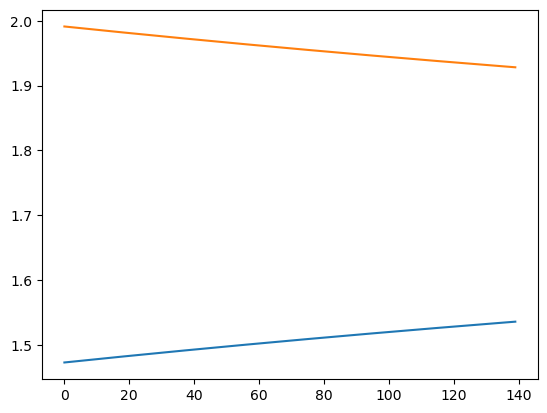

In [ ]:
plt.plot(rest_shapes.mean(axis=1)[:, 0, 0])
plt.plot(rest_shapes.mean(axis=1)[:, 1, 1])

# ????

## Analyze a simulation

In [ ]:
#| notest
%matplotlib inline

In [ ]:
# calculate the shape tensor energies

energies = [{key: val for key, val in msh.get_shape_energy(mod_bulk=mod_bulk, mod_shear=mod_shear).items()
             if val is not None} for msh in meshes]
angle_penalties = [msh.get_angle_deviation() for msh in meshes]

(0.0, 0.005)

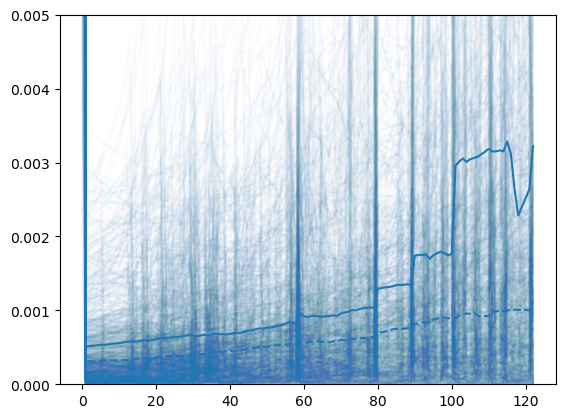

In [ ]:
# time series plot of angle penalties

a_time = np.array([[e[key] for e in angle_penalties] for key in angle_penalties[0].keys()])
plt.plot(a_time.T, color="tab:blue", alpha=.01);
plt.plot(np.mean(a_time, axis=0), color="tab:blue", alpha=1);
plt.plot(np.median(a_time, axis=0), color="tab:blue", alpha=1, ls="--");

plt.ylim([0, 5*1e-3])

In [ ]:
np.arcsin(np.quantile(list(angle_penalties[-10].values()), 0.99)) * 180/ pi

1.0893798185361212

(0.0, 1.0)

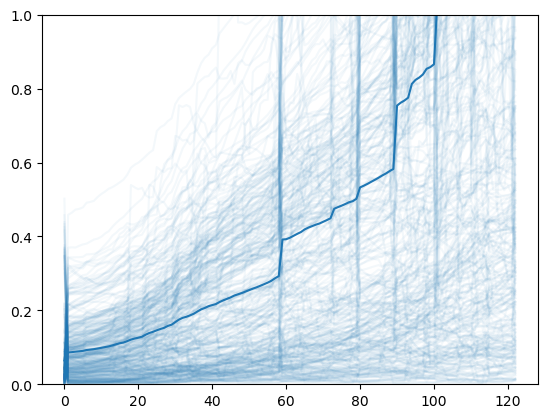

In [ ]:
# time series plot of energies

e_time = np.array([[e[key] for e in energies] for key in energies[0].keys()])
plt.plot(e_time.T, color="tab:blue", alpha=.05);
plt.plot(e_time.mean(axis=0), color="tab:blue", alpha=1);

plt.ylim([0, 10*1e-1])

<matplotlib.collections.PathCollection>

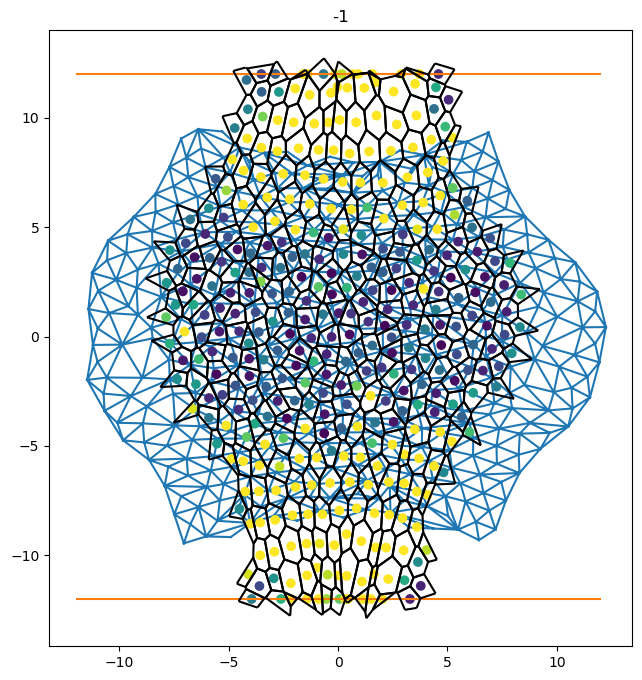

In [ ]:
# spatial plot of shape energies

i = -1

fig = plt.figure(figsize=(8,8))

plt.hlines((bdry_y, -bdry_y), (-12, -12), (12, 12), color="tab:orange")
#plt.ylim([-max_y-.5, max_y+.5])
plt.gca().set_aspect("equal", adjustable="box")
meshes[i].cellplot()
meshes[i].triplot()
#meshes[i].labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

plt.title(i);

# now calculate the energies and centroids
for_scttr = np.stack([np.hstack([np.mean([fc.dual_coords
                                  for fc in meshes[i].vertices[key].get_face_neighbors()], axis=0), [val]])
                     for key, val in energies[i].items()], axis=-1)

plt.scatter(*for_scttr[:2], c=for_scttr[2], vmin=0, vmax=1)

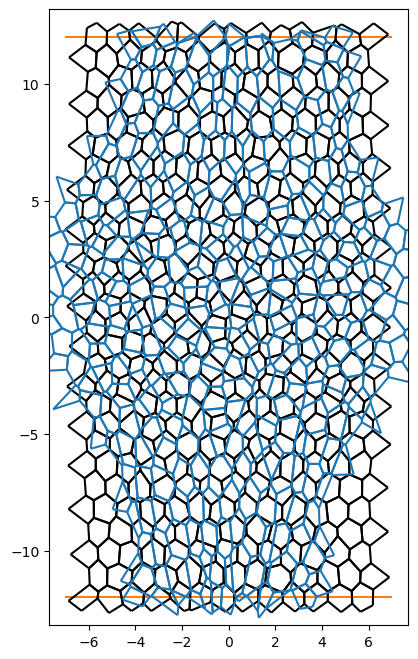

In [ ]:
fig = plt.figure(figsize=(8,8))

plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="tab:orange")
plt.gca().set_aspect("equal", adjustable="box")
meshes[1].cellplot()
meshes[-1].cellplot(edge_colors={he: "tab:blue" for he in meshes[-1].hes.keys()})


(0.0, 1.7320508075688772)

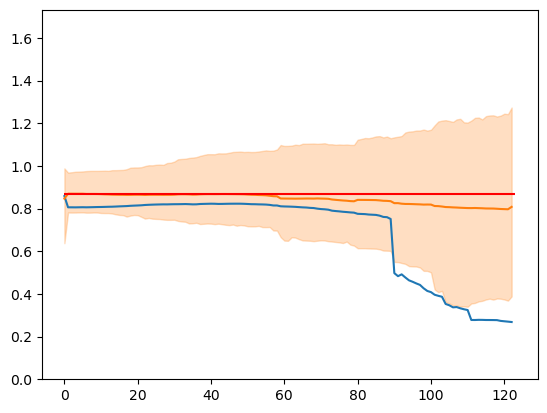

In [ ]:
# create a time-series of areas

areas = np.stack([[x for x in msh.get_areas().values() if ~np.isnan(x)] for msh in meshes])

plt.plot(areas[:, 3])
mean = areas.mean(axis=1)

plt.plot(mean)
plt.fill_between(np.arange(areas.shape[0]), np.quantile(areas, .05, axis=1),
                 np.quantile(areas, .95, axis=1), color="tab:orange", alpha=.25)

plt.hlines(sqrt(3)/2, 0, len(meshes), color="r")
plt.ylim([0, sqrt(3)])


<IPython.core.display.Javascript object>


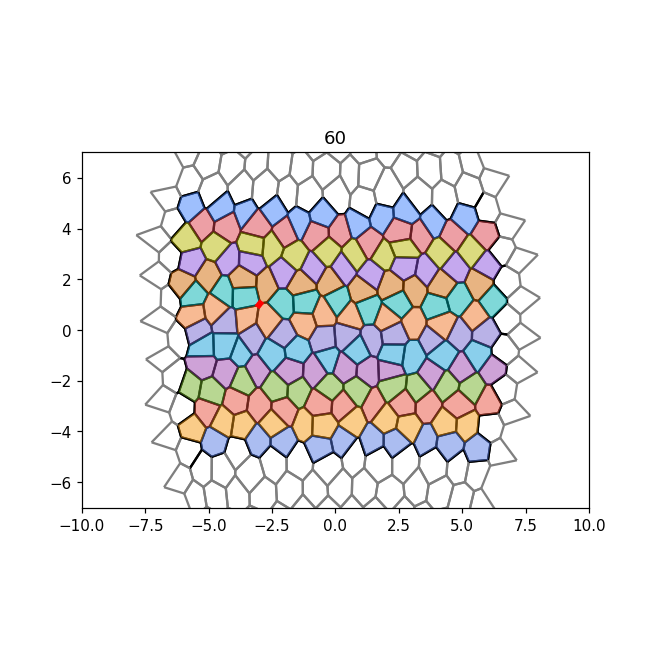

interactive(children=(IntSlider(value=61, description='i', max=122), Output()), _dom_classes=('widget-interact…

In [ ]:
#| notest

%matplotlib notebook

fig = plt.figure(figsize=(6, 6)) # 10,01

plot_cell = True
plot_tri = False

def plot_mesh(i):
    plt.cla()
    plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="tab:orange")
    plt.xlim([-10, 10])
    #plt.ylim([-bdry_y-1, bdry_y+1])
    plt.ylim([-7, 7])
    #plt.xlim([-15, -5])
    #plt.ylim([-10, 0])
    plt.gca().set_aspect("equal", adjustable="box")
    if plot_cell:
        meshes[i].cellplot(edge_colors=edge_colors,
                           cell_colors=cell_colors
                          )
    #meshes[i].labelplot(halfedge_labels=True, vertex_labels=True, face_labels=False)
    if plot_tri:
        meshes[i].triplot()
    plt.title(i)
    for x in last_flipped_edges[i+1]:
        he = meshes[i].hes[x]
        if plot_cell:
            line = np.stack([he.face.dual_coords, he.twin.face.dual_coords])
            plt.plot(*line.T, c="r", lw=4)
        if plot_tri:
            line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
            plt.plot(*line.T, c="tab:purple", lw=5)
        
widgets.interact(plot_mesh, i=(0, len(meshes)-1, 1));

In [ ]:
# 1, 36
# y: 0-5

## Angle at the moment of T1 in active cells

It seems that we can generate fairly extremely obtuse triangles. How can this be? Should be eliminated by T1. Why not? Let's quantify the angles at T1s and check.

This can happen in triangle cells where T1s are not possible anymore!

## extension vs time

In [ ]:
#| notest
%matplotlib inline


In [ ]:
centroids = np.stack([[v.get_centroid() for v in msh.vertices.values()
                       if not v._vid in passive_cells and not v.is_bdry()]  for msh in meshes])
centroids = (centroids.transpose((1,0,2)) - centroids.mean(axis=1)).transpose((1,0,2))

moments = np.stack([get_inertia(x, q=0) for x in centroids])

(88, 2)


[<matplotlib.lines.Line2D>]

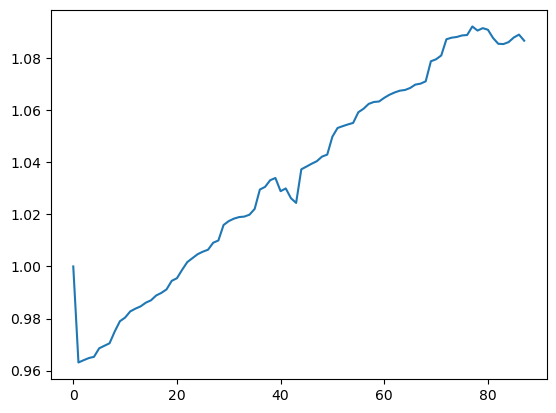

In [ ]:
delta = np.quantile(centroids, axis=1, q=.95)-np.quantile(centroids, axis=1, q=.1, )
print(delta.shape)

plt.plot(delta[:,0]/delta[0,0]) # does extension saturate?
#plt.plot(delta[:,1]/delta[0,1])  # convergence saturates at .5x

[<matplotlib.lines.Line2D>]

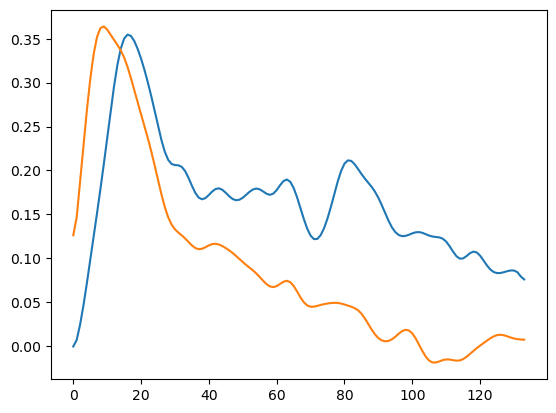

In [ ]:
plt.plot(np.gradient(ndimage.gaussian_filter1d(delta[:,0], sigma=3)[3:-3]))
plt.plot(-np.gradient(ndimage.gaussian_filter1d(delta[:,1], sigma=3)[3:-3]))

(-6.4832018586469635,
 6.748551938396517,
 -7.062197437401586,
 7.1508934337745815)

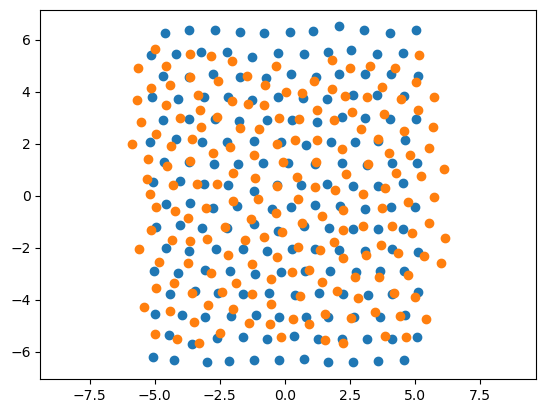

In [ ]:
plt.scatter(*centroids[1].T)

plt.scatter(*centroids[-1].T)

#plt.scatter(*centroids[179].T)

plt.axis("equal")

In [ ]:
moments[0], moments[90], moments[179]

(array([[12.33253995, -0.11735014],
        [-0.11735014, 33.43998948]]),
 array([[43.23537488, -0.46945584],
        [-0.46945584,  8.9875649 ]]),
 array([[64.21514419, -1.51310622],
        [-1.51310622,  6.83221804]]))

[<matplotlib.lines.Line2D>]

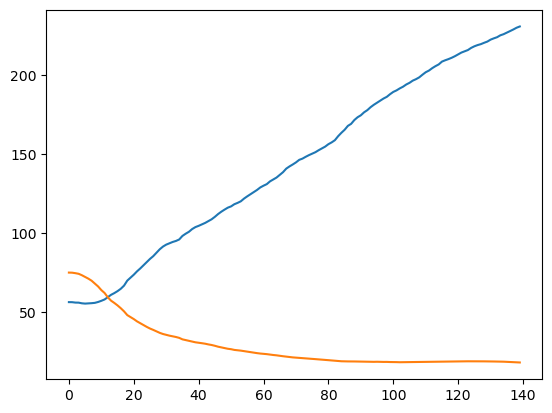

In [ ]:
#plt.plot(moments[:, 0,0])

#plt.plot(jnp.sqrt(moments[:, 0,0]/moments[:, 1,1]))

plt.plot(moments[:,0,0])

plt.plot(moments[:,1,1])

expansion certainly saturates in delaunay! Note: increase in area so not that much convergence

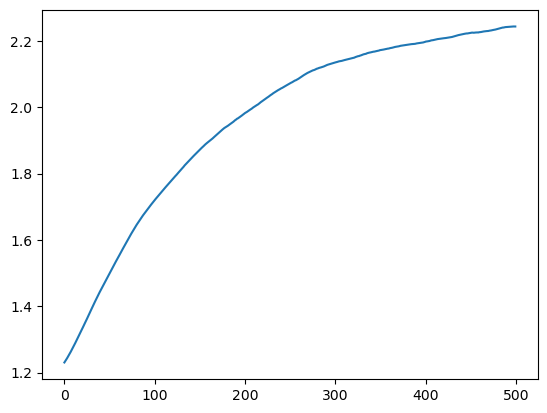

## Plot trajectories of cell centroids, colored along trajectory by time

Say every third or so cell

In [ ]:
trajectories = [[val.get_centroid() for key, val in msh.vertices.items()
                if (not mesh_initial.vertices[key].is_bdry())] for msh in meshes]

trajectories = np.stack(trajectories).transpose((1,0,2))

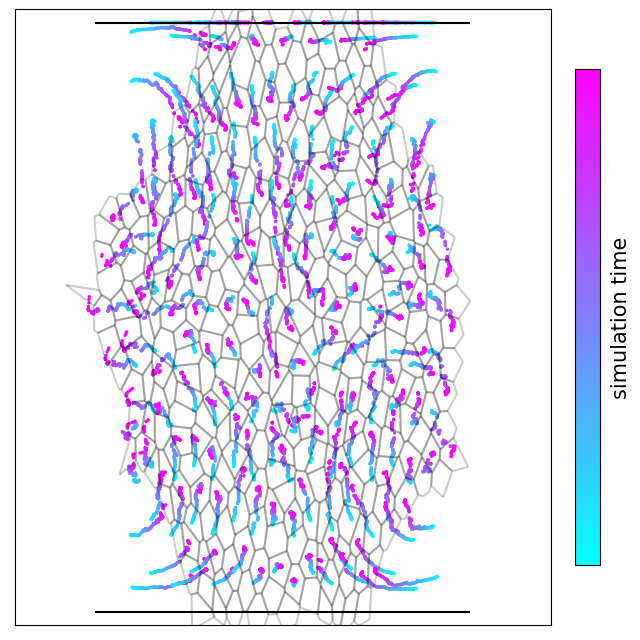

In [ ]:
fig = plt.figure(figsize=(8,8))

t = np.arange(trajectories.shape[1])

stop = -1

for traj in trajectories[::2]:
    plt.scatter(*traj[1:stop].T, s=2, c=t[1:stop], cmap="cool")

cb = plt.colorbar(fraction=0.04, pad=0.04)
cb.set_ticks([])
cb.set_label(label='simulation time', fontsize=15)

meshes[stop].cellplot(alpha=.2)

plt.xticks([],[])
plt.yticks([],[])

plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="black", label="slip wall")
plt.xlim([-10, 10])
plt.ylim([-bdry_y-.5, bdry_y+.5])
plt.gca().set_aspect("equal", adjustable="box")

#plt.savefig("plots/trajectories_v2.pdf")

In [ ]:
#| notest
def plot_mesh(i, ylim):
    plt.cla()
    plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="tab:orange")
    plt.xlim([-2.5, 2.5])
    plt.ylim(ylim)
    #plt.xlim([-2., 2])
    #plt.ylim([0, 4])
    plt.gca().set_aspect("equal", adjustable="box")
    meshes[i].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
    plt.xticks([],[])
    plt.yticks([],[])

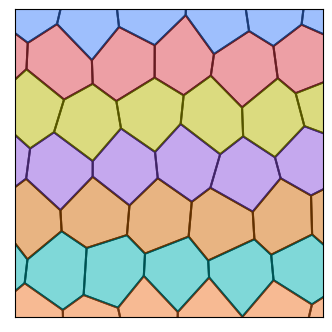

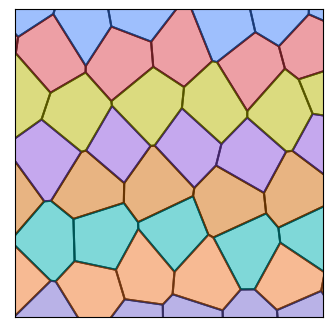

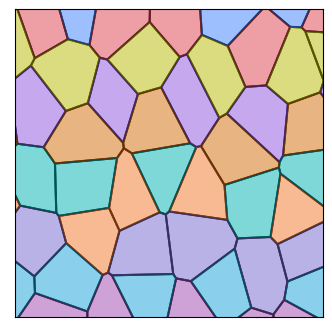

In [ ]:
fig = plt.figure(figsize=(4, 4))
plot_mesh(1, ylim=(.5,5.5))
plt.savefig("plots/snapshot_initial_v2.pdf")
plt.show()

fig = plt.figure(figsize=(4, 4))
plot_mesh(35, ylim=(-.2, 4.8))
plt.savefig("plots/snapshot_intermediate_v2.pdf")
plt.show()

fig = plt.figure(figsize=(4, 4))
plot_mesh(110, ylim=(-1.1, 3.9))
plt.savefig("plots/snapshot_final_v2.pdf")
plt.show()

## Compute triangle order parameter in active cells

Histogram based approach

In [ ]:
def get_shape_order_param(triangle):
    alpha, beta, gamma = triangle
    x = sqrt(3)*sin(alpha)*sin(alpha+2*beta)
    y = (cos(alpha)*cos(alpha+2*beta) - cos(2*alpha))
    psi = np.arctan2(x, y) + pi

    Psi = 6+2*(cos(4*triangle)-cos(2*triangle) - cos(2*(triangle-np.roll(triangle, 1, axis=0)))).sum(axis=0)
    Psi /= (3-cos(2*triangle).sum(axis=0))**2
    Psi = np.sqrt(Psi)
    
    psi_tilde = pi - np.abs((3*psi) % (2*pi) - pi)
    
    return np.array([psi_tilde, Psi])

In [ ]:
def get_vertex_angles(msh, method="real", exclude=None):
    exclude = [exclude] if exclude is None else exclude
    if method == "dual":
        lengths = [np.array([np.linalg.norm(x.vertices[1].coords-x.vertices[0].coords) for x in fc.hes])
                   for fc in msh.faces.values() if (not (fc._fid in exclude))]
        angles = np.array([sides_angles(x) for x in lengths])
    if method == "real":
        angles = []
        for fc in msh.faces.values():
            if (not (fc._fid in exclude)) and (not fc.is_bdr()):
                vecs = np.stack([he.twin.face.dual_coords-fc.dual_coords for he in fc.hes])
                angle = [np.pi-vectors_angle(x, y) for x,y in zip(vecs, np.roll(vecs, 1, axis=0))]
                angles.append(np.array(angle))
        angles = np.array(angles)
    
    return angles

In [ ]:
def scatter_hist(x, y, bins, ax, ax_histx, ax_histy, ticks_off=True, vmin=None, vmax=None):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    if ticks_off:
        ax_histx.set_yticks([],[])
        ax_histy.set_xticks([],[])

    # the scatter plot:
    ax.hist2d(x, y, bins=bins, density=True, cmap="magma", vmin=vmin, vmax=vmax)

    ax_histx.hist(x, bins=bins[0], alpha=.5, density=True)
    ax_histy.hist(y, bins=bins[1], orientation='horizontal', alpha=.5, density=True)
    
def eqspace(x0, x1, dx):
    return np.linspace(x0, x1, np.round(abs(x1-x0)/dx).astype(int))

In [ ]:
angle_series = [get_vertex_angles(msh, exclude=passive_ids, method="real") for msh in meshes] # passive_ids

dsf_series = [get_shape_order_param(x.T) for x in angle_series]

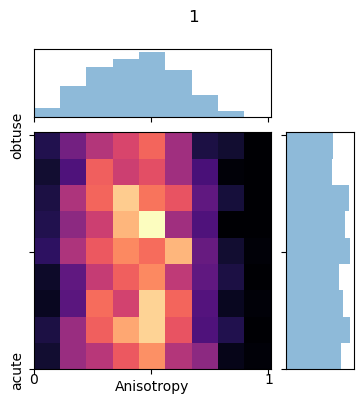

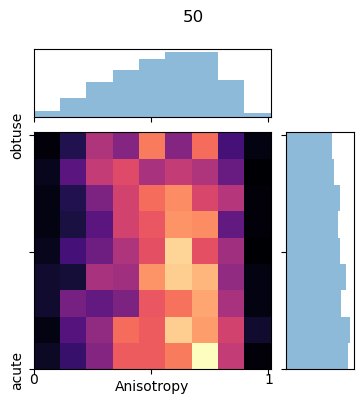

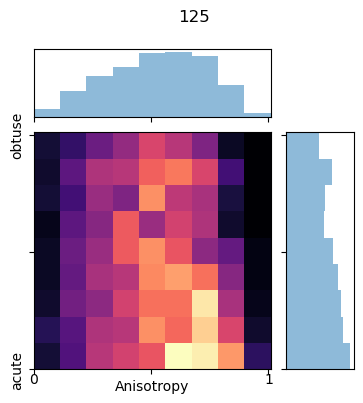

In [ ]:
for t in [1, 50, 125]:

    fig = plt.figure(figsize=(4,4))
    fig.suptitle(f'{t}', y=1.)

    gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                          left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.1, hspace=0.1)
    ax = fig.add_subplot(gs[1, 0])
    ax_histx, ax_histy = (fig.add_subplot(gs[0, 0], sharex=ax), fig.add_subplot(gs[1, 1], sharey=ax))

    bins = [eqspace(0, 1+.01, .1), eqspace(0, 1+.01, .1)]
    scatter_hist(dsf_series[t][1], dsf_series[t][0]/np.pi, bins, ax, ax_histx, ax_histy)
    
    ax.set_ylabel("", labelpad=-5)
    ax.set_xlabel("Anisotropy", labelpad=-5)
    ax.set_xticks([0, 1/2, 1], [0, "", 1], rotation=0, va='center') 
    ax.set_yticks([0, 1/2, 1], ["acute", "", r"obtuse"], rotation=90, va='center')
    #ax.set_aspect('equal', adjustable='box')
    plt.show()

Text(-0.075, 0.5, 'Probability [%]')

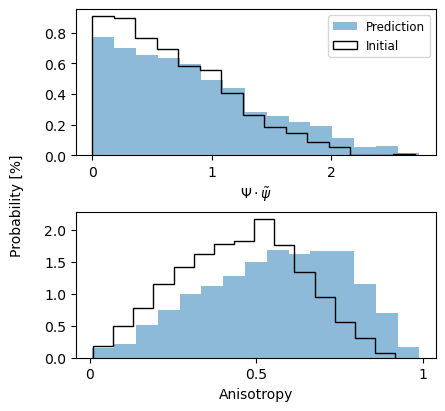

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize=(4,4), ncols=1, nrows=2, constrained_layout = True)

t_sim = 80

n_bins = 15

ax1.hist(np.prod(dsf_series[t_sim], axis=0), alpha=.5, bins=n_bins, density=True, label='Prediction');
ax1.hist(np.prod(dsf_series[2], axis=0), bins=n_bins, density=True, label='Initial',
         histtype='step', color='k', );

#ax1.set_ylabel(r"Probability [%]",)
#plt.ylim([0, 0.7])
ax1.set_xlabel(r"$\Psi\cdot\tilde{\psi}$",)
ax1.legend(fontsize=8.5)

ax2.hist(dsf_series[t_sim][1], alpha=.5, bins=n_bins, density=True, label='Prediction');
ax2.hist(dsf_series[2][1], bins=n_bins, density=True, label='Initial',
         histtype='step', color='k', );

ax2.set_xlabel(r"Anisotropy")
#fig.supylabel("Probability [%]")
#plt.ylim([0, 0.7])

ax1.set_xticks([0, 1, 2], [0, 1, 2])
ax2.set_xticks([0, 0.5, 1,], [0, 0.5, 1,])


#fig.tight_layout()


fig.text(-0.075, 0.5, 'Probability [%]', va='center', rotation='vertical')

In [ ]:
# shift towards obtuse triangles, as captured by bridge parameter, is much weaker in disordered simulation
# than in mean field. why? test against delaunay flip simulation. might be an aspect of the 
# triangle flattening??

# or is it the isogonal mode? Here it is 0! it is the isogonal mode. with collapse at pi/2, the mean field
# gives the same result!

# test also with different initial condition. is euler step working correctly?

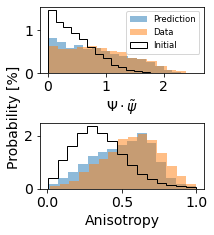

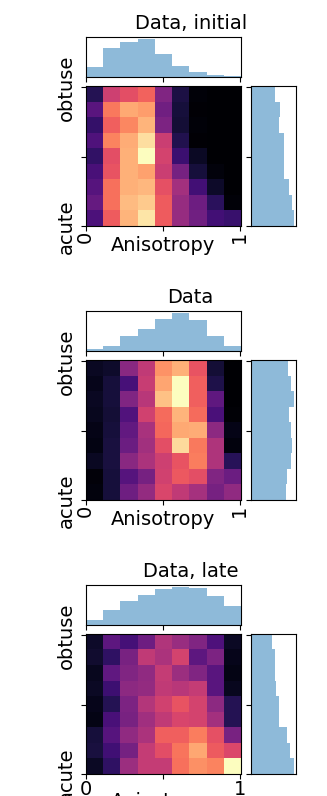

### Create and save an animation

In [ ]:
#| notest
%matplotlib inline

# Save simulation as HTML5 animation

# create the figure and axes objects
fig = plt.figure(facecolor="white", dpi=300)
nframes, frame_dt = n_steps, 500  # Delay between frames in milliseconds

def animate_meshes(n):
    n = n+1
    plt.cla()
    plt.hlines((bdry_y, -bdry_y), (-7, -7), (7, 7), color="tab:orange")
    plt.xlim([-11, 11])
    plt.ylim([-bdry_y-.5, bdry_y+.5])
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title('')
    meshes[n].cellplot(edge_colors=edge_colors, cell_colors=cell_colors)
    #meshes[n].triplot()
    for x in last_flipped_edges[n+1]:
        he = meshes[n].hes[x]
        line = np.stack([he.vertices[0].coords, he.vertices[1].coords])
        #plt.plot(*line.T, c="tab:purple", lw=2)
        line = np.stack([he.face.dual_coords, he.twin.face.dual_coords])
        plt.plot(*line.T, c="r", lw=2)
    if n == nframes-1:
        plt.close()

# run the animation
anim = animation.FuncAnimation(fig, animate_meshes, frames=71, interval=frame_dt, repeat=False)
anim.save('plots/germ_band_medium_parr.mp4', fps=4,)
# maybe best to start from 1